In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import os
from fancyimpute import KNN

imagedir = 'images'
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)
# For numeric stability
EPSILON = 1e-10

df = pd.read_csv('ListingsAndSales.csv')

# not sold flag
df['NotSoldFlag'] = 0
df.loc[df['SalesDate'].isnull() == True, 'NotSoldFlag'] = 1
print('percent not yet sold:', df['NotSoldFlag'].mean())

df.ListingDate, df.SalesDate = [
    pd.to_datetime(col) for col in [df.ListingDate, df.SalesDate]
]
df.SalesDate = df.SalesDate.fillna(df.SalesDate.max())

# Get day of dataset for each sample
df['ListingDay'] = (df.ListingDate - df.ListingDate.min()).dt.days
df = df.sort_values('ListingDay')

# calculate days it took to sell the listing if it's sold
df['DaysSold'] = (df.SalesDate - df.ListingDate).dt.days.astype(float) + 1

# loop through the variables and replace missing values with avg and create dummy variables
col_dates = ['ListingDate', 'SalesDate']

# Columns to use as regressors
X = df.drop(['DaysSold', 'ListingDate', 'SalesDate', 'NotSoldFlag'], axis=1)

#Use 3 nearest rows which have a feature to fill in each row's missing features
X = pd.DataFrame(KNN(k=5).complete(X))


# Column to use as target
Y = df[['DaysSold']].as_matrix().astype(np.float32)

scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(X)).as_matrix().astype(np.float32)
sold = df['NotSoldFlag'].as_matrix().astype(np.float32)
n_features = X.shape[1]


class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes

        self.sold = tf.placeholder(tf.float32, shape=(None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))

        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(
                tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)

        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))

        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) *
                               (1 - self.sold) + self.sold)
        loss_numerator = tf.reduce_sum(
            tf.square(self.y - self.output) * self.loss_indicator)
        loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
        self.loss = loss_numerator / loss_denominator

        self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        self.trn_losses = []
        self.val_losses = []
        self.r2_scores = []

    def train_one_epoch(self, trn_samples, bs, X_train, Y_train, sold_train):
        # Train an epoch
        trn_loss = []
        # Randomly shuffle data and prepare for training
        order = np.arange(trn_samples)
        np.random.shuffle(order)
        num_batches = (trn_samples // bs) + 1
        for itr in range(trn_samples // bs):
            rows = order[itr * bs:(itr + 1) * bs]
            if itr + 1 == num_batches:
                rows = order[itr * bs:]
            X_active, Y_active, Sold_active = [
                mat[rows] for mat in [X_train, Y_train, sold_train]
            ]
            feed_dict = {
                self.x: X_active,
                self.y: Y_active,
                self.sold: Sold_active
            }
            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict)
            trn_loss.append(loss)
        self.trn_losses.append(np.mean(trn_loss))

    def validate(self, X_test, Y_test, sold_test):
        feed_dict = {self.x: X_test, self.y: Y_test, self.sold: sold_test}
        val_loss, yhat = self.sess.run([self.loss, self.output], feed_dict)
        self.val_losses.append(val_loss)
        self.r2_scores.append(r2_score(Y_test, yhat))

    def train(self, X, Y, sold, epochs):
        # Train the model based on X,Y,sold data for a set number of epochs
        n_samples = X.shape[0]
        trn_samples = (n_samples * 4) // 5
        bs = 64
        
        # Let's randomly split the data here between train and test.
        # We will do better in a later version.
        samples = np.arange(n_samples)
        trn_s = np.random.choice(samples, size=trn_samples, replace=False)
        val_samples = [s for s in samples if s not in trn_s]
        X_train, X_test = X[trn_s], X[val_samples]
        Y_train, Y_test = Y[trn_s], Y[val_samples]
        sold_train, sold_test = sold[trn_s], sold[val_samples]

        # Everything is set. Now train and validate
        for epoch in range(epochs):
            # run one epoch train and validation
            self.train_one_epoch(trn_samples, bs, X_train, Y_train, sold_train)
            self.validate(X_test, Y_test, sold_test)
            
            if epoch % 10 == 0:
                # Occasionally print to command line to inspect performance
                print('epoch:', epoch, 'train loss: ', self.trn_losses[-1],
                      'val loss: ', self.val_losses[-1], 'r2_score:',
                      self.r2_scores[-1])

    def visualize(self, name):
        # Visualize training and validation losses and r2 scores on one plot
        _, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.trn_losses, label='train loss')
        ax1.plot(self.val_losses, label='test loss')
        ax2.plot(self.r2_scores, label='validation r2_scores', color='g')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('least square losses')
        ax2.set_ylabel('R2 Scores')
        ax2.legend()
        ax1.legend()
        plt.title('Losses and r2 scores for ' + name)
        plt.savefig(imagedir + '/' + name + '.jpg')
        plt.show()


percent not yet sold: 0.6864035087719298
Imputing row 1/4104 with 2 missing, elapsed time: 2.416
Imputing row 101/4104 with 2 missing, elapsed time: 2.422
Imputing row 201/4104 with 2 missing, elapsed time: 2.427
Imputing row 301/4104 with 2 missing, elapsed time: 2.431
Imputing row 401/4104 with 2 missing, elapsed time: 2.435
Imputing row 501/4104 with 2 missing, elapsed time: 2.440
Imputing row 601/4104 with 2 missing, elapsed time: 2.445
Imputing row 701/4104 with 2 missing, elapsed time: 2.449
Imputing row 801/4104 with 2 missing, elapsed time: 2.454
Imputing row 901/4104 with 3 missing, elapsed time: 2.458
Imputing row 1001/4104 with 2 missing, elapsed time: 2.463
Imputing row 1101/4104 with 2 missing, elapsed time: 2.468
Imputing row 1201/4104 with 3 missing, elapsed time: 2.472
Imputing row 1301/4104 with 2 missing, elapsed time: 2.477
Imputing row 1401/4104 with 3 missing, elapsed time: 2.483
Imputing row 1501/4104 with 2 missing, elapsed time: 2.488
Imputing row 1601/4104 with

epoch: 0 train loss:  717.97906 val loss:  705.50183 r2_score: -0.06654357446829007
epoch: 10 train loss:  679.5883 val loss:  671.5214 r2_score: -0.017766144813477158
epoch: 20 train loss:  642.67694 val loss:  635.03217 r2_score: 0.036302535589867846
epoch: 30 train loss:  602.87177 val loss:  598.4734 r2_score: 0.0877830364355835
epoch: 40 train loss:  567.41974 val loss:  565.19574 r2_score: 0.13488076088083079
epoch: 50 train loss:  537.52484 val loss:  534.47095 r2_score: 0.1780161369078883
epoch: 60 train loss:  510.2937 val loss:  505.62592 r2_score: 0.21791639623787817
epoch: 70 train loss:  484.6486 val loss:  479.3928 r2_score: 0.25482703667375517
epoch: 80 train loss:  459.34875 val loss:  455.36255 r2_score: 0.2888643959855859
epoch: 90 train loss:  437.19992 val loss:  432.75784 r2_score: 0.3205444494844707


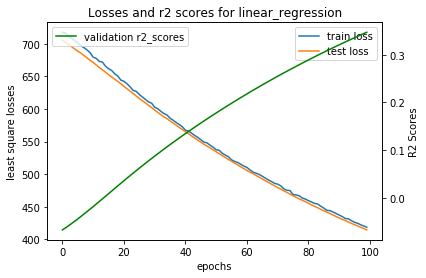

In [27]:
model = Model(n_features, layer_sizes=[])
model.train(X, Y, sold, epochs=100)
model.visualize('linear_regression')

epoch: 0 train loss:  716.11536 val loss:  673.3762 r2_score: -0.021576428014683957
epoch: 10 train loss:  218.68787 val loss:  208.42928 r2_score: 0.6481643447364749
epoch: 20 train loss:  189.0268 val loss:  181.6312 r2_score: 0.6839561466134971
epoch: 30 train loss:  185.29532 val loss:  178.18692 r2_score: 0.6886250835999479
epoch: 40 train loss:  183.62735 val loss:  177.35156 r2_score: 0.6903715022612325
epoch: 50 train loss:  182.06876 val loss:  175.7575 r2_score: 0.6924705666560707
epoch: 60 train loss:  181.62895 val loss:  175.34914 r2_score: 0.6932911327035716
epoch: 70 train loss:  181.31868 val loss:  174.9852 r2_score: 0.6938867992774091
epoch: 80 train loss:  180.7218 val loss:  173.38916 r2_score: 0.6951807644238187
epoch: 90 train loss:  179.9287 val loss:  172.81256 r2_score: 0.6957310412162735


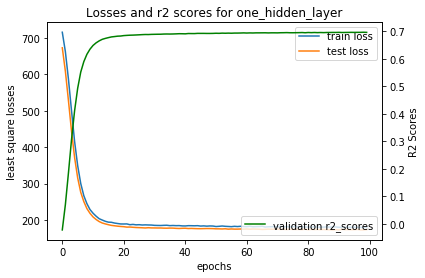

In [28]:
model = Model(n_features, layer_sizes=[64])
model.train(X, Y, sold, epochs=100)
model.visualize('one_hidden_layer')

epoch: 0 train loss:  674.2632 val loss:  577.84686 r2_score: 0.1355218753268711
epoch: 10 train loss:  181.73611 val loss:  182.70665 r2_score: 0.6826791522125812
epoch: 20 train loss:  177.78961 val loss:  179.99529 r2_score: 0.6865156948367399
epoch: 30 train loss:  175.97768 val loss:  180.79828 r2_score: 0.6878633998530952
epoch: 40 train loss:  174.49825 val loss:  180.6712 r2_score: 0.6891697998526906
epoch: 50 train loss:  173.58617 val loss:  177.36319 r2_score: 0.6911494544545066
epoch: 60 train loss:  172.24127 val loss:  178.88608 r2_score: 0.690301683299639
epoch: 70 train loss:  170.0991 val loss:  179.73758 r2_score: 0.6910880619371593
epoch: 80 train loss:  169.11124 val loss:  181.01286 r2_score: 0.6914390500976728
epoch: 90 train loss:  167.90352 val loss:  175.85623 r2_score: 0.6949225496033204


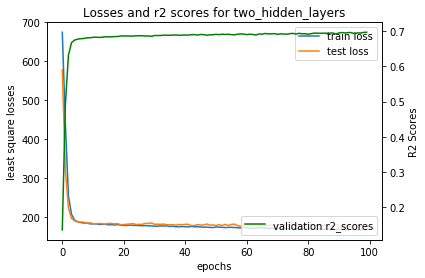

In [29]:
model = Model(n_features, layer_sizes=[64, 64])
model.train(X, Y, sold, epochs=100)
model.visualize('two_hidden_layers')